<a href="https://colab.research.google.com/github/rahul-rajendra-kumar/Dissertation_Project/blob/main/Dog_Jigsaw_20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import random
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from PIL import Image, ImageChops
from scipy import stats
from imageio import imsave
from skimage.util.shape import view_as_blocks
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import Dense, Input, concatenate, Conv2D, Reshape,MaxPooling2D, Lambda,Activation,Conv2DTranspose, UpSampling2D, merge
from keras.layers import UpSampling2D, Conv2DTranspose, BatchNormalization, Dropout
from keras.callbacks import TensorBoard, ModelCheckpoint, Callback, ReduceLROnPlateau
from keras.regularizers import l1
from keras.optimizers import SGD, Adam
import keras.backend as K
from keras.utils import plot_model
from keras.callbacks import TensorBoard, ModelCheckpoint, Callback
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from random import randint
from keras.models import load_model
from imageio import imsave
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from random import randint
%matplotlib inline

In [ ]:
drive.mount('/content/drive/', force_remount=True)
%cd /content/drive/My\ Drive/PROJECTS/CNN/

Mounted at /content/drive/
/content/drive/My Drive/PROJECTS/CNN


In [ ]:
jigsaw = 'dog.jpg'
shuffled_image_location = "shuffled_20_images.npy"
shuffled_label_location = "shuffled_20_labels.npy"
rotation_label_location = "rotation_20_lables.npy"
height,width,classes,n = 224,224,16,4
samples = 20
image_datagen = ImageDataGenerator()

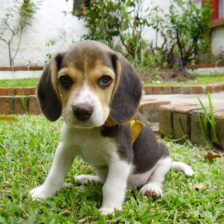

In [ ]:
image = Image.open(jigsaw)
display(image)

In [ ]:
class Label_Generator:
  def __init__(self, n=4, count=5000, rotate=False):
    self.n = n
    self.count = count
    self.rotate = rotate
  
  def generate_initial_label(self):
    label = np.zeros((self.image.shape[0],self.image.shape[1]),dtype=np.uint8)
    for row in range(0,self.n):
      for col in range(0,self.n):
        x,y = row*self.tile_size,col*self.tile_size
        x_next,y_next = x+self.tile_size,y+self.tile_size
        label[x:x_next,y:y_next] = np.full((self.tile_size,self.tile_size),row*self.n+col)
    self.label = label
  
  def shuffle_and_generate_labels(self):
    image_blocks = view_as_blocks(self.image, block_shape = (self.tile_size, self.tile_size, 3)).reshape((-1, self.tile_size, self.tile_size, 3))
    label_blocks = view_as_blocks(self.label, block_shape = (self.tile_size, self.tile_size)).reshape((-1, self.tile_size, self.tile_size))
    self.image_shuffle = np.zeros((self.image.shape[0], self.image.shape[1],3), dtype=np.uint8)
    self.label_shuffle = np.zeros((self.label.shape[0], self.label.shape[1]), dtype=np.uint8)
    self.label_rotated = np.zeros((self.label.shape[0]//self.tile_size, self.label.shape[1]//self.tile_size), dtype=np.uint8)

    positions = np.arange(self.n*self.n, dtype=np.uint8)
    permutations = np.random.permutation(positions)
    map = {key:value for key,value in zip(positions,permutations)}

    for row in range(0,self.n):
      for col in range(0,self.n):
        x,y = row*self.tile_size,col*self.tile_size
        x_next,y_next = x+self.tile_size,y+self.tile_size
        if(self.rotate):
          rotation_value = random.randrange(0,4)
          self.label_rotated[row,col]=rotation_value
          self.image_shuffle[x:x_next, y:y_next] = np.rot90(image_blocks[map[row*self.n+col]],rotation_value)
          self.label_shuffle[x:x_next, y:y_next] = label_blocks[map[row*self.n+col]]
        else:
          self.image_shuffle[x:x_next, y:y_next] = image_blocks[map[row*self.n+col]]
          self.label_shuffle[x:x_next, y:y_next] = label_blocks[map[row*self.n+col]]

  def generate_labels(self, image):    
    shuffled_images = []
    shuffled_labels = []
    rotation_lables = []
    # for i in images:
    image = Image.open(image).convert('RGB')
    # image = image.resize((224, 224))
    self.image = np.array(image)
    # self.image = image
    self.tile_size = self.image.shape[0]//self.n
    self.generate_initial_label()
    for j in range(0,self.count):
      self.shuffle_and_generate_labels()
      shuffled_images.append(self.image_shuffle)
      shuffled_labels.append(self.label_shuffle)
      rotation_lables.append(self.label_rotated)
    shuffled_images = np.array(shuffled_images)
    np.save(shuffled_image_location, shuffled_images)
    shuffled_labels = np.array(shuffled_labels)
    np.save(shuffled_label_location, shuffled_labels)
    rotation_lables = np.array(rotation_lables)
    np.save(rotation_label_location, rotation_lables)

  def scramble_image(self,image):
    self.image = np.array(image) #np.array(Image.open(image).convert('RGB'))
    self.tile_size = self.image.shape[0]//self.n
    self.generate_initial_label()
    self.shuffle_and_generate_labels()
    return self.image_shuffle,self.label_shuffle,self.label_rotated

  def unscramble_image(self,image,shuffle_key,rotation_key):
    self.image = image
    self.tile_size = self.image.shape[0]//self.n
    map = {}
    image_blocks = view_as_blocks(image, block_shape = (self.tile_size, self.tile_size, 3)).reshape((-1, self.tile_size, self.tile_size, 3))
    rotation_key = rotation_key.flatten()
    self.image_shuffle = np.zeros((image.shape[0], image.shape[0],3), dtype=np.uint8)
    for row in range(0,self.n):
      for col in range(0,self.n):
        x,y = row*self.tile_size,col*self.tile_size
        x_next,y_next = x+self.tile_size,y+self.tile_size
        map[row*self.n+col] = stats.mode(shuffle_key[x:x_next, y:y_next] ,axis=None)[0][0]
    inverse_map = {value:key for key,value in map.items()}
    for row in range(0,self.n):
      for col in range(0,self.n):
        x,y = row*self.tile_size,col*self.tile_size
        x_next,y_next = x+self.tile_size,y+self.tile_size
        self.image_shuffle[x:x_next, y:y_next] = np.rot90(image_blocks[inverse_map[row*self.n+col]], (rotation_key[inverse_map[row*self.n+col]]*3)%4)
    return self.image_shuffle

In [ ]:
generator = Label_Generator(n,samples,True)
generator.generate_labels(jigsaw)

In [ ]:
x_image = np.load(shuffled_image_location)
y_slabel = np.load(shuffled_label_location)
y_rlabel = np.load(rotation_label_location)

In [ ]:
image_count = x_image.shape[0]
x_image = np.float32(x_image/255.0)
y_slabel = y_slabel.reshape((image_count,224,224,1))
y_rlabel = y_rlabel.reshape((image_count,n,n,1))

print(x_image.shape)
print(y_slabel.shape)
print(y_rlabel.shape)

X_train, X_val, y_train, y_val, z_train, z_val = train_test_split(x_image, y_slabel, y_rlabel, test_size=0.20, random_state=42)
(X_train.shape, X_val.shape, y_train.shape, y_val.shape, z_train.shape, z_val.shape)

(20, 224, 224, 3)
(20, 224, 224, 1)
(20, 4, 4, 1)


((16, 224, 224, 3),
 (4, 224, 224, 3),
 (16, 224, 224, 1),
 (4, 224, 224, 1),
 (16, 4, 4, 1),
 (4, 4, 4, 1))

In [ ]:
class Model_Generator:
  def generate_sequential_data(self, generator, x, y_shuffle, y_rotation):
    self.x = generator.flow(x, seed=7, batch_size=32)
    self.y1 = generator.flow(y_shuffle, seed=7, batch_size=32)
    self.y2 = generator.flow(y_rotation, seed=7, batch_size=32)
    
    while True:
            x_val = self.x.next()
            y1_val = self.y1.next().reshape(-1,50176,1)
            y2_val = self.y2.next().reshape(-1,16,1)
            yield (x_val, {'shuffle': y1_val, 'rotation': y2_val})
  
  def conv_block(self, tensor, nfilters, size=3, padding='same', kernel_initializer = 'he_normal'):
    x = Conv2D(filters=nfilters, kernel_size=(size,size) , padding=padding, kernel_initializer = 'he_normal')(tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

  def deconv_block(self, tensor, residual, nfilters, size=3, padding='same', kernel_initializer = 'he_normal'):
    y = UpSampling2D(size = (2,2))(tensor)
    y = Conv2D(filters=nfilters, kernel_size=(size,size), activation = 'relu', padding = 'same', kernel_initializer = kernel_initializer)(y)
    y = concatenate([y,residual], axis = 3)
    y = self.conv_block(y, nfilters)
    return y
    
  def get_model(self):
    inputs = Input((224,224,3))
    
    #Contraction path
    conv1= self.conv_block(inputs, 16)
    pool1 = MaxPooling2D(pool_size=2)(conv1)

    conv2 = self.conv_block(pool1, 32)
    pool2 = MaxPooling2D(pool_size=2)(conv2)
   

    conv3 = self.conv_block(pool2, 64)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = self.conv_block(pool3, 128)
    pool4 = MaxPooling2D(pool_size=2)(conv4)
   
    conv5 = self.conv_block(pool4, 256)
   
    
    #Expansion path
    up6 = self.deconv_block(conv5, conv4, 128)
    up7 = self.deconv_block(up6, conv3, 64)
    up8 = self.deconv_block(up7, conv2, 32)
    up9 = self.deconv_block(up8, conv1, 16)
    

    conv10 = Conv2D(16, kernel_size=(1, 1))(up9)
    out1 = BatchNormalization()(conv10)
    out1 = Reshape((height*width, classes), input_shape=(height, width, classes))(out1)
    out1 = Activation('softmax', name="shuffle")(out1)
     
    pool_fin = MaxPooling2D(pool_size=2)(up9)
    conv11 = Conv2D(4, kernel_size=(28, 28), strides=(28, 28))(pool_fin)
    out2 = BatchNormalization()(conv11)
    out2 = Reshape((-1, 4), input_shape=(4, 4, 4))(out2)
    out2 = Activation('softmax', name= "rotation")(out2)
    
    losses = { "shuffle": "sparse_categorical_crossentropy",
	             "rotation": "sparse_categorical_crossentropy" }
             
    lossWeights = {"shuffle": 1.0, "rotation": 1.0}

    model = Model(inputs=[inputs], outputs=[out1, out2])
    model.compile(optimizer = Adam(lr = 1e-4), loss=losses, loss_weights=lossWeights, metrics = ['sparse_categorical_accuracy'])

    return model

 
gen = Model_Generator()
train_data = gen.generate_sequential_data(image_datagen,X_train,y_train,z_train)
validation_data = gen.generate_sequential_data(image_datagen,X_val,y_val,z_val)
model=gen.get_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 224, 224, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
filepath="dog-model-20-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_weights_only=False , save_best_only=True, mode='min')
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=15, min_lr=0.00001, verbose=1)
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0,
                          write_graph=True, write_images=True)

callbacks_list = [tensorboard, checkpoint,reduce_lr]

In [ ]:
run_info = model.fit(
    train_data,
    epochs=100,
    steps_per_epoch=100,
    validation_data=validation_data,
    validation_steps=10,
    callbacks=callbacks_list)

Epoch 1/100
100/100 [==============================] - 19s 137ms/step - loss: 3.2471 - shuffle_loss: 2.7664 - rotation_loss: 0.4807 - shuffle_sparse_categorical_accuracy: 0.1695 - rotation_sparse_categorical_accuracy: 0.9073 - val_loss: 4.8896 - val_shuffle_loss: 3.6302 - val_rotation_loss: 1.2593 - val_shuffle_sparse_categorical_accuracy: 0.1107 - val_rotation_sparse_categorical_accuracy: 0.4219

Epoch 00001: val_loss improved from inf to 4.88959, saving model to model_10_10-01-4.89.hdf5
Epoch 2/100
100/100 [==============================] - 4s 42ms/step - loss: 1.6944 - shuffle_loss: 1.3980 - rotation_loss: 0.2964 - shuffle_sparse_categorical_accuracy: 0.7211 - rotation_sparse_categorical_accuracy: 0.9952 - val_loss: 4.8349 - val_shuffle_loss: 3.3756 - val_rotation_loss: 1.4593 - val_shuffle_sparse_categorical_accuracy: 0.1434 - val_rotation_sparse_categorical_accuracy: 0.4062

Epoch 00002: val_loss improved from 4.88959 to 4.83486, saving model to model_10_10-02-4.83.hdf5
Epoch 3/10

In [ ]:
train_loss=run_info.history['loss']
val_loss=run_info.history['val_loss']
rotation_loss = run_info.history['rotation_loss']
shuffle_loss = run_info.history['shuffle_loss']

rotation_sparse_categorical_accuracy=run_info.history['rotation_sparse_categorical_accuracy']
shuffle_sparse_categorical_accuracy=run_info.history['shuffle_sparse_categorical_accuracy']
val_rotation_sparse_categorical_accuracy=run_info.history['val_rotation_sparse_categorical_accuracy']
val_shuffle_sparse_categorical_accuracy=run_info.history['val_shuffle_sparse_categorical_accuracy']
xc=range(100)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.plot(xc,rotation_loss)
plt.plot(xc,shuffle_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train_LossVSVal_Loss')
plt.grid(True)
plt.legend(['Train_Loss','Val_Loss','Rotation_Loss','Shuffle_Lose'])
# plt.style.available#usebmh,classic,ggplotforbigpictures
# plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,rotation_sparse_categorical_accuracy)
plt.plot(xc,shuffle_sparse_categorical_accuracy)
plt.plot(xc,val_rotation_sparse_categorical_accuracy)
plt.plot(xc,val_shuffle_sparse_categorical_accuracy)

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train_AccVSVal_Acc')
plt.grid(True)
plt.legend(['rotation_sparse_categorical_accuracy','shuffle_sparse_categorical_accuracy','val_rotation_sparse_categorical_accuracy','val_shuffle_sparse_categorical_accuracy'],loc=4)
#printplt.style.available#usebmh,classic,ggplotforbigpictures
plt.style.use(['classic'])
plt.show()

In [ ]:
# generator = Label_Generator(n,samples,True)
# f = plt.figure(figsize=(15,15))
# #Load the model
# model = load_model('cifar10_model-399-0.00.hdf5',compile=False)
# for i in Image_set1:
#   i = Image.open(i).convert('RGB')
#   i = image.resize((224, 224))
#   i = np.array(image)
#   # Generate a random shuffle-input 
#   f.add_subplot(1, 3, 1).set_title('Test Scramble')
#   generator = Label_Generator(n,samples,True)
#   input_image,shuffle_key,rotation_key = generator.scramble_image(i)
#   plt.imshow(input_image)
#   # Predict output
#   image_1 = np.float32(input_image/255.0)
#   sout,rout = model.predict(image_1.reshape(1,224,224,3))
#   # Extract sparse labels
#   sout = np.uint8(np.argmax(sout,axis=2)).reshape((224,224))
#   rout = np.uint8(np.argmax(rout,axis=2)).reshape((4,4))

#   generator = Label_Generator(n,samples,True)
#   model_output_image = generator.unscramble_image(np.uint8(input_image),sout,rout)
#   f.add_subplot(1, 3, 2).set_title('Model Prediction')
#   plt.imshow(model_output_image)
#   #Genrate Expected Output
#   generator = Label_Generator(n,samples,True)
#   output_image = generator.unscramble_image(input_image,shuffle_key,rotation_key)
#   f.add_subplot(1, 3, 3).set_title('Expected Image')
#   plt.imshow(output_image)
#   plt.show()

In [ ]:
model = load_model('dog-model-20-99-0.05.hdf5', compile = False)
image = Image.open(jigsaw).convert('RGB')
image = image.resize((224, 224))
tp = []
images = []
for i in range(200):
  generator = Label_Generator(n,samples,True)
  input_image,shuffle_key,rotation_key = generator.scramble_image(image)
  out_image = generator.unscramble_image(input_image,shuffle_key,rotation_key)
  image_1 = np.float32(input_image/255.0)
  sout,rout = model.predict(image_1.reshape(1,224,224,3))
  sout = np.uint8(np.argmax(sout,axis=2)).reshape((224,224))
  rout = np.uint8(np.argmax(rout,axis=2)).reshape((4,4))
  generator = Label_Generator(n,samples,True)
  try:
    model_output_image = generator.unscramble_image(np.uint8(input_image),sout,rout)
    im1 = Image.fromarray(out_image)
    im2 = Image.fromarray(model_output_image)
    diff = np.array(ImageChops.difference(im2, im1))
    diff_array = np.array(diff)
    num = len(diff_array[0])//4
    c = 0
    for i in diff_array:
      for j in [i[:num],i[num:2*num],i[2*num:3*num],i[3*num:]]:
        if sum(sum(j)) == 0:
          c+=1
    tp.append(c/(224//4))
    images.append(image)
    images.append(input_image)
    images.append(model_output_image)
  except:
    pass

tp = pd.DataFrame(tp,columns=['times'])
fig = px.histogram(tp,x = 'times')
fig.update_layout(xaxis_title = 'Count of correct predictions out of 16', yaxis_title='Count of occurance in 200 test runs', title='Histogram of accuracy of prediction')
fig.show()

In [ ]:
tp

[]

In [ ]:
x = len(images)//3
if x>0:
  if x>100:
    y = x//3
    y1 = images[:y]
    y2 = images[y:y+y]
    y3 = images[y+y:]
    for i in [y1,y2,y3]:
      z = len(y1)//3
      fig = plt.figure(figsize=(20, 3*z))
      grid = ImageGrid(fig, 111, nrows_ncols=(z, 3), axes_pad=0.1)
      for ax, im in zip(grid, images):
          ax.imshow(im)

      plt.show()
  else:
    fig = plt.figure(figsize=(20, 3*x))
    grid = ImageGrid(fig, 111, nrows_ncols=(x, 3), axes_pad=0.1)
    for ax, im in zip(grid, images):
        ax.imshow(im)
else:
  print("No predictions made")

No predictions made


In [ ]:
# score = model.evaluate(x_test, y_test, verbose=0)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])
len(images)//2

7